Problem 1

Parameters of the largest circle:
Center: (251, 175)
Radius: 13
Range of σ values used: 0.01 to 6.609999999999999


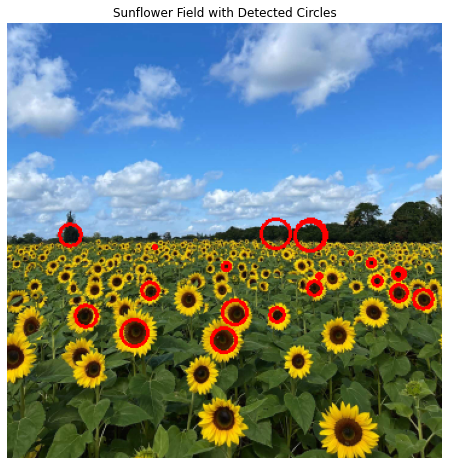

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)


# Variables
min_radius = 1  # Minimum circle radius
max_radius = 600 # Maximum circle radius
sigma_values = np.arange(0.01, 6.9, 0.3)  # Range of sigma values to use

# Initialize an empty list to store detected circles
circles = []

for sigma in sigma_values:
    # Apply Gaussian blur with the current sigma
    blurred = cv.GaussianBlur(gray, (0, 0), sigmaX=sigma)
    
    # Apply Laplacian of Gaussian (LoG) to find zero-crossings
    log = cv.Laplacian(blurred, cv.CV_64F)
    
    # Find the local extrema in the LoG image
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(log)
    
    # Threshold the LoG image to detect extrema
    threshold = 0.3
    if max_val > threshold:
        radius = int(sigma * 2)
        
        if min_radius <= radius <= max_radius:
            circles.append((max_loc[0], max_loc[1], radius))


circles.sort(key=lambda x: x[2], reverse=True)

largest_circle = circles[0]

center_x, center_y, radius = largest_circle

print("Parameters of the largest circle:")
print(f"Center: ({center_x}, {center_y})")
print(f"Radius: {radius}")
print(f"Range of σ values used: {sigma_values[0]} to {sigma_values[-1]}")


im_with_circles = im_rgb.copy()
# Draw circles on the copy of the image
for circle in circles:
    center_x, center_y, radius = circle
    cv.circle(im_with_circles, (center_x, center_y), radius, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(im_with_circles)
plt.title("Sunflower Field with Detected Circles")
plt.axis("off")
plt.show()


Problem 2

Problem 03

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
#Mouse clicking

k = 0
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])


def Homography(imgPoints, flagPoints):
    A = []
    for i in range(4):
        A.append([flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],0,0,0,
        -imgPoints[i][0]*flagPoints[i][0],-imgPoints[i][0]*flagPoints[i][1],-imgPoints[i][0]*flagPoints[i][2]])
        A.append([0,0,0,flagPoints[i][0],flagPoints[i][1],flagPoints[i][2],
        -imgPoints[i][1]*flagPoints[i][0],-imgPoints[i][1]*flagPoints[i][1],-imgPoints[i][1]*flagPoints[i][2]])
    A = np.array(A,dtype = np.float64)
    AAT = A.T @ A
    w, v = np.linalg.eig(AAT)
    H = v[:, np.argmin(w)]
    H = H.reshape((3,3))
    H = H/H[-1,-1]
    return H

img = cv.imread('001.jpg',cv.IMREAD_ANYCOLOR)
cv.imshow("IMG",img)
imgPoints = []
cv.setMouseCallback("IMG",mousePoint)
k = cv.waitKey(0)
if k ==ord('q'): 
    cv.destroyAllWindows()


imgFlag = cv.imread('sl.png',cv.IMREAD_ANYCOLOR)
flagheight,flagWidth = imgFlag.shape[0],imgFlag.shape[1]
flagPoints = np.array([[0,0,1],[flagWidth,0,1],[flagWidth,flagheight,1],[0,flagheight,1]])
imgPoints = np.array(imgPoints)
H = Homography(imgPoints,flagPoints)
print('H= ',H)

rows,cols,ch = img.shape
warpedImg = cv.warpPerspective(imgFlag,H,(cols,rows))
overlayImg = cv.add(img, warpedImg)
fig,ax = plt.subplots(1,4,figsize = (30,15))
warpedImg = cv.cvtColor(warpedImg, cv.COLOR_BGR2RGB)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgFlag = cv.cvtColor(imgFlag, cv.COLOR_BGR2RGB)
overlayImg = cv.cvtColor(overlayImg, cv.COLOR_BGR2RGB)

ax[0].imshow(img)
ax[0].set_title("structural image")
ax[1].imshow(imgFlag)
ax[1].set_title("Flag")
ax[3].imshow(overlayImg)
ax[3].set_title("Overlayed Image")

AttributeError: 'NoneType' object has no attribute 'shape'

Problem 4

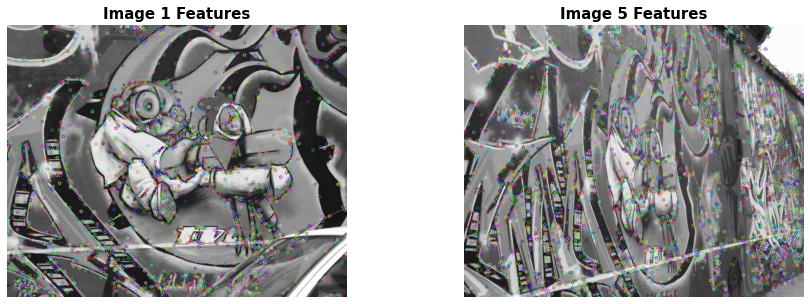

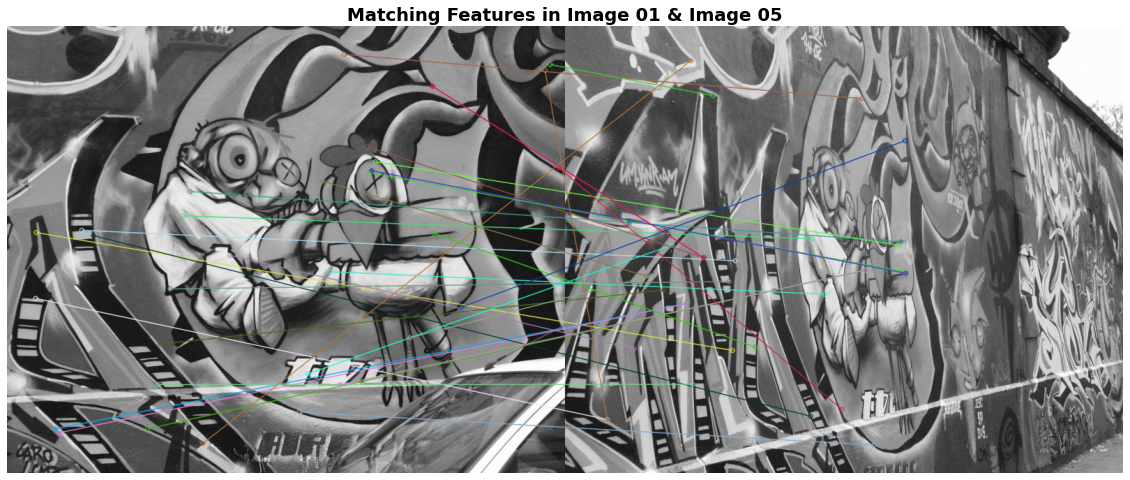

In [78]:
im1 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img1.ppm", cv.IMREAD_GRAYSCALE)
im5 = cv.imread(r"D:\Acadamics\semester 5\Image Processing - 3\A02 Fitting and Alignment\A02-Fitting-and-Alignment\Graf\img5.ppm", cv.IMREAD_GRAYSCALE)


# Create a SIFT object
sift = cv.SIFT_create()

# Detect and compute keypoints and descriptors for both images
kp1, descs1 = sift.detectAndCompute(im1, None)
kp2, descs2 = sift.detectAndCompute(im5, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)

# Create a FLANN matcher
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descs1, descs2, k=2)

# Apply ratio test to get good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw good matches on a new image
im3 = cv.drawMatches(im1, kp1, im5, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Create images with keypoints drawn
kp_im_1 = cv.drawKeypoints(im1, kp1, None)
kp_im_5 = cv.drawKeypoints(im5, kp2, None)

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(cv.cvtColor(kp_im_1, cv.COLOR_BGR2RGB))
ax[0].set_title("Image 1", fontweight="bold", fontsize=15)
ax[0].axis("off")

ax[1].imshow(cv.cvtColor(kp_im_5, cv.COLOR_BGR2RGB))
ax[1].set_title("Image 5 ", fontweight="bold", fontsize=15)
ax[1].axis("off")
plt.show()

# Display the matching features
fig = plt.figure(figsize=(20, 20))
plt.imshow(cv.cvtColor(im3, cv.COLOR_BGR2RGB))
plt.title("Matching Features of Image 01 & Image 05", fontweight="bold", fontsize=18)
plt.axis('off')
plt.show()
